# Prepare Data 

## Import libraries

In [22]:
import requests
import pandas as pd
import pandas_ta as ta
import talib 
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

## Wrangling

In [23]:
def wrangle(symbol: str, interval: str, start_time: str = None, end_time: str = None, limit: int = 1000):
    base_url = "https://api.binance.com/api/v3/klines"

    params = {
        "symbol": symbol,
        "interval": interval.lower(),
        "limit": limit
    }

    if start_time:
        params["startTime"] = start_time
    if end_time:
        params["endTime"] = end_time

    valid_intervals = ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
    if interval.lower() not in valid_intervals:
        raise ValueError(f"Invalid interval: {interval}. Valid intervals are: {', '.join(valid_intervals)}")

    response = requests.get(base_url, params=params)
    response.raise_for_status()

    data = response.json()

    df = pd.DataFrame(data, columns=[
        "open_time", "open", "high", "low", "close", "volume", "close_time",
        "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume",
        "taker_buy_quote_asset_volume", "ignored"
    ])

    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")

    df["open"] = df["open"].astype(float)
    df["high"] = df["high"].astype(float)
    df["low"] = df["low"].astype(float)
    df["close"] = df["close"].astype(float)
    df["volume"] = df["volume"].astype(float)
    df.set_index('open_time', inplace=True)
    df.dropna(inplace = True)


    return df

# Fetching data
historical_data = wrangle("BTCUSDT", "1h", limit=1500)
historical_data.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignored
open_time,,,,,,,,,,,
2024-05-19 06:00:00,67097.63,67150.00,66930.40,67022.65,362.78212,2024-05-19 06:59:59.999,24319644.99600970,26140,169.79155000,11382564.10201260,0
2024-05-19 07:00:00,67022.64,67329.45,66981.10,67324.44,825.69502,2024-05-19 07:59:59.999,55469515.46686570,32895,485.14817000,32595327.15660690,0
2024-05-19 08:00:00,67324.44,67339.91,67100.00,67160.01,453.96065,2024-05-19 08:59:59.999,30511111.60218480,25545,204.72460000,13759643.22155740,0
2024-05-19 09:00:00,67160.00,67186.67,66990.01,67180.01,449.59565,2024-05-19 09:59:59.999,30156576.39650110,23281,178.23186000,11954753.62318440,0
2024-05-19 10:00:00,67180.01,67700.00,67116.35,67269.99,1871.51463,2024-05-19 10:59:59.999,126211786.95504330,66648,1061.18273000,71566555.31069500,0


## Explore

/home/younes/.local/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


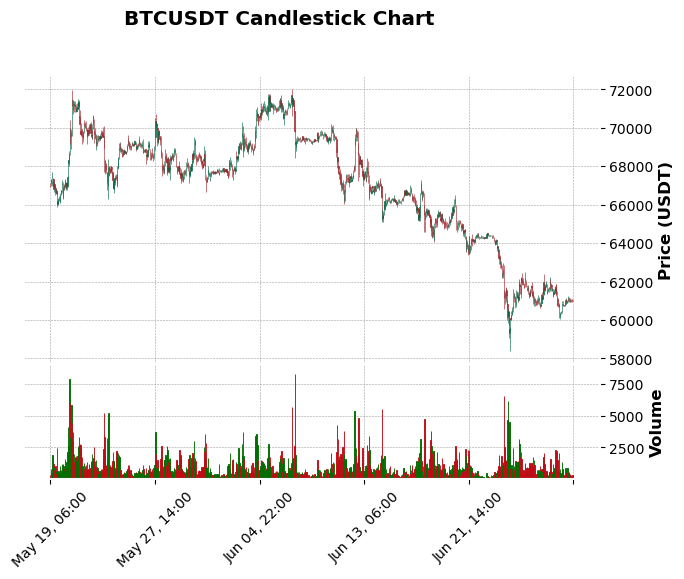

In [24]:

# Plotting the candlestick chart
mpf.plot(historical_data, type='candle', style='charles', title='BTCUSDT Candlestick Chart',
         ylabel='Price (USDT)', ylabel_lower='Volume', volume=True, show_nontrading=False
        )
plt.show()

#  Applying technical indicators

### Short Term Indicators

In [25]:
def short_term_indicators(data):
    historical_data.dropna(inplace=True)
    # Calculate RSI
    data['RSI'] = ta.rsi(data['close'], length=14)
    historical_data.dropna(inplace=True)

    # Calculate Bollinger Bands
    bbands = ta.bbands(data['close'], length=20)
    data['BB_upper'] = bbands['BBU_20_2.0']
    data['BB_middle'] = bbands['BBM_20_2.0']
    data['BB_lower'] = bbands['BBL_20_2.0']
    historical_data.dropna(inplace=True)

    # Calculate Volatility (e.g., using ATR)
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'], length=14)
    historical_data.dropna(inplace=True)

    
    # Calculate Commodity Channel Index (CCI)
    data['CCI'] = ta.cci(data['high'], data['low'], data['close'], length=20)
    historical_data.dropna(inplace=True)    
    # Drop missing values 
    data.dropna(subset=["RSI", "BB_upper", "BB_middle", "BB_lower", "ATR", "CCI"], inplace=True)

    return data

historical_data = short_term_indicators(historical_data)
historical_data.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignored,RSI,BB_upper,BB_middle,BB_lower,ATR,CCI
open_time,,,,,,,,,,,,,,,,,
2024-05-22 00:00:00,70148.34,70279.99,70049.99,70120.01,1023.24236,2024-05-22 00:59:59.999,71789373.91306260,40929,463.58153000,32522649.58233550,0,52.590642,71654.067556,70397.8915,69141.715444,543.598878,-32.346599
2024-05-22 01:00:00,70120.00,70209.10,70007.73,70159.58,811.91424,2024-05-22 01:59:59.999,56920357.25603850,34208,333.10261000,23351740.52520590,0,53.144501,71548.060878,70345.3775,69142.694122,519.153958,-30.826436
2024-05-22 02:00:00,70159.57,70368.60,69922.77,70003.01,1132.34656,2024-05-22 02:59:59.999,79409212.58633380,42606,493.39342000,34603187.35828220,0,50.624377,71428.717849,70285.2575,69141.797151,513.916532,-29.401025
2024-05-22 03:00:00,70003.01,70050.00,69822.76,69955.72,744.84482,2024-05-22 03:59:59.999,52092402.30703660,39263,346.74268000,24248512.04922480,0,49.855387,71357.329206,70239.1290,69120.928794,493.439637,-45.290606
2024-05-22 04:00:00,69955.72,70000.00,69165.00,69599.98,1368.72361,2024-05-22 04:59:59.999,95182590.97868490,66413,556.15657000,38672881.57553980,0,44.392535,71279.277381,70173.3280,69067.378619,517.836806,-89.345952


### Indicators Features

In [26]:
print(historical_data[['close', 'RSI', 'BB_upper', 'BB_lower', 'ATR', 'CCI']].tail())

                        close        RSI      BB_upper      BB_lower  \
open_time                                                              
2024-06-29 17:00:00  61040.77  51.905801  61297.772216  60482.533784   
2024-06-29 18:00:00  61059.04  52.577753  61260.192680  60589.218320   
2024-06-29 19:00:00  61057.39  52.506404  61206.651135  60705.714865   
2024-06-29 20:00:00  61050.00  52.164968  61208.547451  60731.747549   
2024-06-29 21:00:00  60972.02  48.575436  61209.979450  60737.414550   

                            ATR        CCI  
open_time                                   
2024-06-29 17:00:00  224.751674  53.957375  
2024-06-29 18:00:00  214.055126  59.627863  
2024-06-29 19:00:00  209.195474  48.259834  
2024-06-29 20:00:00  202.710083  51.977963  
2024-06-29 21:00:00  193.945077  22.434097  


In [27]:
print(historical_data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignored', 'RSI', 'BB_upper',
       'BB_middle', 'BB_lower', 'ATR', 'CCI'],
      dtype='object')


### Explore indicators for short term

#### Relative Strength Index

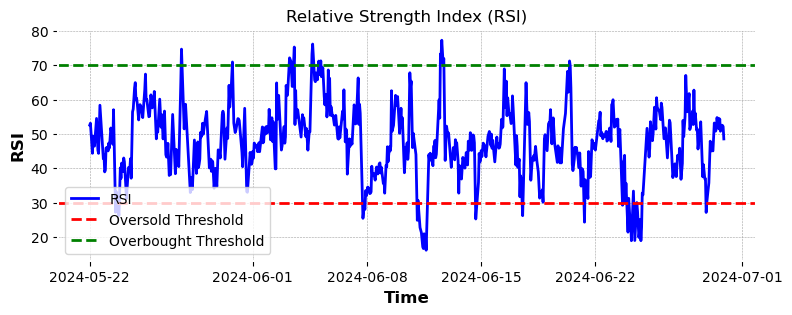

In [28]:
# Assuming historical_data is already prepared with 'open_time' as the index and other indicators calculated
historical_data['RSI'] = pd.to_numeric(historical_data['RSI'], errors='coerce')
historical_data.dropna(subset=['RSI'], inplace=True)
index_values = historical_data.index.to_numpy()
rsi_values = historical_data['RSI'].to_numpy()

# Plotting RSI
plt.figure(figsize=(9, 3))
plt.plot(index_values, rsi_values, label='RSI', color='blue')
plt.axhline(y=30, color='r', linestyle='--', label='Oversold Threshold')
plt.axhline(y=70, color='g', linestyle='--', label='Overbought Threshold')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Time')
plt.ylabel('RSI')
plt.legend()

#### Interpretation 
- When RSI <= 30 indicate oversold opportunites and when  RSI >= 70 indicate overbought opportunites.

#### Bollinger Bands

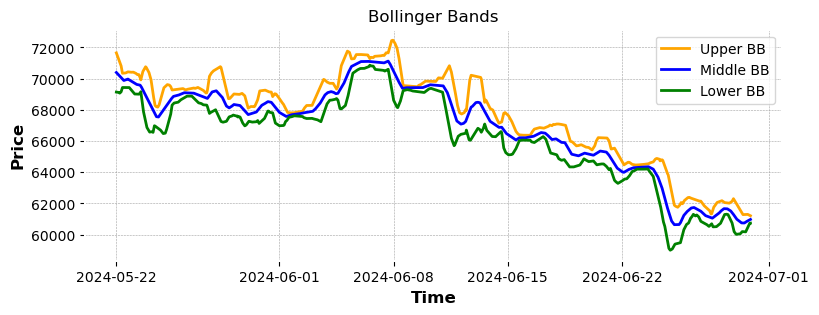

In [29]:
# Plotting Bollinger Bands
plt.figure(figsize=(9, 3))
plt.plot(index_values, historical_data['BB_upper'].values, label='Upper BB', color='orange')
plt.plot(index_values, historical_data['BB_middle'].values, label='Middle BB', color='blue')
plt.plot(index_values, historical_data['BB_lower'].values, label='Lower BB', color='green')
plt.title('Bollinger Bands')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

#### Interpretation 
- Bollinger Bands provide a relative definition of high and low prices.
- The bands widen when the price volatility increases and narrow when the price volatility decreases.
- When the price touches the upper band, it may be considered overbought.
- When the price touches the lower band, it may be considered oversold.

#### Average True Range

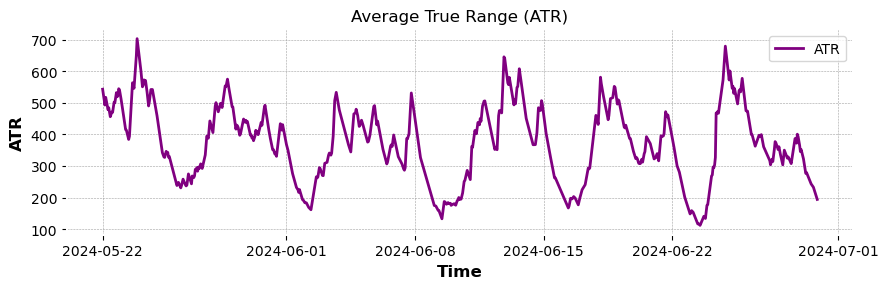

In [30]:
# Assuming historical_data is already prepared with 'open_time' as the index and other indicators calculated
ATR_values = historical_data['ATR'].to_numpy()
plt.figure(figsize=(9, 3))

# Plotting ATR
plt.plot(index_values, ATR_values, label='ATR', color='purple')
plt.title('Average True Range (ATR)')
plt.xlabel('Time')
plt.ylabel('ATR')
plt.legend()
plt.tight_layout()
plt.show()

#### Interpretation
- Higher ATR values indicate higher volatility.
- Lower ATR values indicate lower volatility.

#### Commodity Channel Index

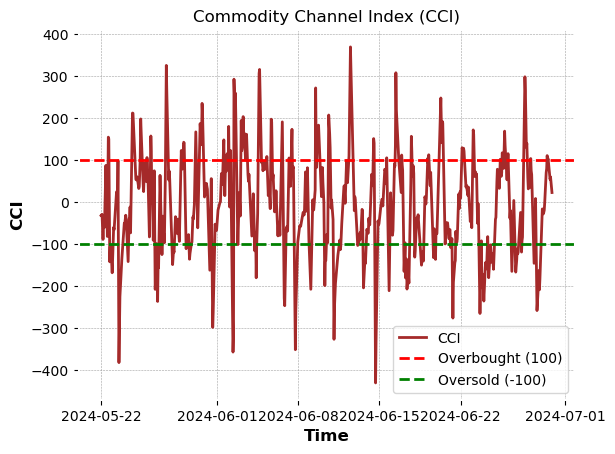

In [31]:
plt.plot(index_values, historical_data['CCI'].values, label='CCI', color='brown')
plt.axhline(y=100, color='r', linestyle='--', label='Overbought (100)')
plt.axhline(y=-100, color='g', linestyle='--', label='Oversold (-100)')
plt.title('Commodity Channel Index (CCI)')
plt.xlabel('Time')
plt.ylabel('CCI')
plt.legend()

#### Interpretation
- Analysts generally use +100 as the upper limit for overbought conditions and -100 as the lower limit for oversold conditions. 

# Implement Trading Strategies For Short Term Strategy

## Strategy Outline

#### Buy Signal:

- RSI Condition: Buy when RSI is less than 30 (indicating oversold condition).
- Bollinger Bands Condition: Buy when the closing price (close) is less than the lower Bollinger Band (BB_lower) plus 1.5 times the Average True Range (ATR), suggesting 
  a bounce off the lower band.
- CCI Condition: Buy when CCI is less than -100 (indicating strong oversold condition).

#### Sell Signal:

- RSI Condition: Sell when RSI is greater than 70 (indicating overbought condition).
- Bollinger Bands Condition: Sell when the closing price (close) is greater than the upper Bollinger Band (BB_upper) minus 1.5 times the Average True Range (ATR), 
  indicating a potential pullback from the upper band.
- CCI Condition: Sell when CCI is greater than 100 (indicating strong overbought condition).

## Short Term Buy Strategy

In [32]:
def buy_strategy(data):
    data['buying_opportunity'] = (
        (data['RSI'] < 30) &                        
        (data['close'] < data['BB_lower'] + 1.5 * data['ATR']) &  
        (data['CCI'] < -100)                        
    )
    return data

## Short Term Sell Strategy

In [33]:
def sell_strategy(data):
    data['selling_opportunity'] = (
        (data['RSI'] > 70) &                        
        (data['close'] > data['BB_upper'] - 1.5 * data['ATR']) &  
        (data['CCI'] > 100)                         
    return data

## Testing and Validation Results

### Buying and Selling Strategy Simple tests

In [34]:
def buy_strategy(data, capital):
    # Calculate position size based on risk percentage
    risk_percentage = 0.02  # Example: Risk 2% of capital per trade
    data['position_size'] = capital * risk_percentage / data['ATR']
    
    # Define buying conditions
    data['buying_opportunity'] = (
        (data['RSI'] < 40) &
        (data['close'] > data['BB_upper'] - 1.5 * data['ATR']) &
        (data['CCI'] < -50)
    )
    
    # Adjust position size to fit capital and risk constraints
    data.loc[data['buying_opportunity'], 'position_size'] = (
        data.loc[data['buying_opportunity'], 'position_size']
        .clip(upper=capital)  # Ensure position size does not exceed available capital
    )
    
    return data

def sell_strategy(data):
    # Define selling conditions
    data['selling_opportunity'] = (
        (data['RSI'] > 60) &
        (data['close'] < data['BB_lower'] + 1.5 * data['ATR']) &
        (data['CCI'] > 50)
    )
    
    return data

# Example usage with initial capital of $10,000
initial_capital = 10000
historical_data = buy_strategy(historical_data, initial_capital)
historical_data = sell_strategy(historical_data)

# Verification
# Check the new columns to verify buying and selling opportunities
buying_opportunities = historical_data[historical_data['buying_opportunity']]

print("Buying Opportunities:")
print(buying_opportunities[['open', 'high', 'low', 'close', 'buying_opportunity', 'position_size']])

selling_opportunities = historical_data[historical_data['selling_opportunity']]

print("\nSelling Opportunities:")
print(selling_opportunities[['open', 'high', 'low', 'close', 'selling_opportunity']])


Buying Opportunities:
                         open      high       low     close  \
open_time                                                     
2024-06-08 22:00:00  69404.90  69404.91  69290.28  69338.15   
2024-06-08 23:00:00  69338.15  69340.00  69292.99  69310.46   
2024-06-09 01:00:00  69268.70  69346.90  69230.00  69285.00   

                     buying_opportunity  position_size  
open_time                                               
2024-06-08 22:00:00                True       1.021927  
2024-06-08 23:00:00                True       1.080571  
2024-06-09 01:00:00                True       1.144716  

Selling Opportunities:
Empty DataFrame
Columns: [open, high, low, close, selling_opportunity]
Index: []


### Trading Strategy Simple test

In [35]:
def trading_strategy(data, capital):

# RSI 
    
    """
    This function implements a trading strategy for BNB based on technical indicators
    and calculates additional metrics for analysis. It also displays key trading information.

    Args:
        data (pandas.DataFrame): DataFrame containing historical OHLC (Open, High, Low, Close) data
            and other relevant technical indicators (RSI, CCI, BB_upper, BB_lower, ATR).
        capital (float): Initial capital available for trading.

    Returns:
        pandas.DataFrame: Modified DataFrame with additional columns for position sizing,
            buying/selling signals, and trading metrics.
    """

    # Apply buying strategy
    data = buy_strategy(data.copy(), capital)

    # Apply selling strategy
    data = sell_strategy(data.copy())

    # Calculate additional metrics
    data['num_buy_signals'] = data['buying_opportunity'].sum()
    data['num_sell_signals'] = data['selling_opportunity'].sum()
    data['total_capital'] = capital

    # Improved profit/loss calculation (assuming constant holding after buy)
    data['profit_loss'] = 0.0
    data.loc[data['buying_opportunity'], 'profit_loss'] = (
        data[data['buying_opportunity']]['close'].iloc[-1] - data[data['buying_opportunity']]['close']
    )

    # Print trading information
    print("Initial Capital:", capital)
    print("Total Profit/Loss: ", data['profit_loss'].sum(), "means that over the trading period or the series of transactions analyzed is loss if <0 and profit if over > 0 ")

    # Example: Display information for the first buy signal (assuming there's at least one)
    if (data['num_buy_signals'] > 0).any():
        first_buy_idx = data[data['buying_opportunity']].index[0]
        print("\nFirst Buy Signal:")
        print("  Entry Time:", first_buy_idx)  # Use index directly to access timestamp
        print("  Entry Price:", data.loc[first_buy_idx, 'close'])
        
        # Check if it's profitable
        if data['profit_loss'].loc[first_buy_idx] > 0:
            last_idx = len(data) - 1
            print("  Close Time:", data.index[last_idx])  # Use index directly to access timestamp
            print("  Close Price:", data.loc[last_idx, 'close'])
        else:
            print("  Sell Not Triggered Yet (consider incorporating actual selling logic)")
    else:
        print("No buy signals found.")

    # Implement actual selling logic based on sell signals
    for sell_idx in data[data['selling_opportunity']].index:
        # Implement your selling logic here, e.g., selling all positions, adjusting capital, etc.
        print(f"\nSell Signal Detected at {sell_idx}:")
        print("  Exit Price:", data.loc[sell_idx, 'close'])

    return data

# Example usage
trading_strategy(historical_data, 1000)

Initial Capital: 1000
Total Profit/Loss:  -78.61000000000058 means that over the trading period or the series of transactions analyzed is loss if <0 and profit if over > 0 

First Buy Signal:
  Entry Time: 2024-06-08 22:00:00
  Entry Price: 69338.15
  Sell Not Triggered Yet (consider incorporating actual selling logic)


,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,BB_lower,ATR,CCI,position_size,buying_opportunity,selling_opportunity,num_buy_signals,num_sell_signals,total_capital,profit_loss
open_time,,,,,,,,,,,,,,,,,,,,,
2024-05-22 00:00:00,70148.34,70279.99,70049.99,70120.01,1023.24236,2024-05-22 00:59:59.999,71789373.91306260,40929,463.58153000,32522649.58233550,...,69141.715444,543.598878,-32.346599,0.036792,False,False,3,0,1000,0.0
2024-05-22 01:00:00,70120.00,70209.10,70007.73,70159.58,811.91424,2024-05-22 01:59:59.999,56920357.25603850,34208,333.10261000,23351740.52520590,...,69142.694122,519.153958,-30.826436,0.038524,False,False,3,0,1000,0.0
2024-05-22 02:00:00,70159.57,70368.60,69922.77,70003.01,1132.34656,2024-05-22 02:59:59.999,79409212.58633380,42606,493.39342000,34603187.35828220,...,69141.797151,513.916532,-29.401025,0.038917,False,False,3,0,1000,0.0
2024-05-22 03:00:00,70003.01,70050.00,69822.76,69955.72,744.84482,2024-05-22 03:59:59.999,52092402.30703660,39263,346.74268000,24248512.04922480,...,69120.928794,493.439637,-45.290606,0.040532,False,False,3,0,1000,0.0
2024-05-22 04:00:00,69955.72,70000.00,69165.00,69599.98,1368.72361,2024-05-22 04:59:59.999,95182590.97868490,66413,556.15657000,38672881.57553980,...,69067.378619,517.836806,-89.345952,0.038622,False,False,3,0,1000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-29 17:00:00,61009.91,61060.98,60937.03,61040.77,339.98388,2024-06-29 17:59:59.999,20739343.12092490,29030,162.32529000,9902670.18000520,...,60482.533784,224.751674,53.957375,0.088987,False,False,3,0,1000,0.0
2024-06-29 18:00:00,61040.77,61065.00,60990.00,61059.04,232.46287,2024-06-29 18:59:59.999,14185354.97168790,22424,104.65356000,6386011.18629820,...,60589.218320,214.055126,59.627863,0.093434,False,False,3,0,1000,0.0
2024-06-29 19:00:00,61059.04,61080.00,60933.98,61057.39,291.28873,2024-06-29 19:59:59.999,17775984.04797230,27037,136.92560000,8355457.41141440,...,60705.714865,209.195474,48.259834,0.095604,False,False,3,0,1000,0.0


# Communicate results


## Summary of Findings

In this project, I explored various technical indicators and implemented trading strategies focused on short-term trading for Binance Coin (BNB). The goal was to identify optimal buy and sell signals using indicators like Relative Strength Index (RSI), Bollinger Bands (BB), Average True Range (ATR), and Commodity Channel Index (CCI).

## Performance Metrics

#### Cumulative Profit/Loss
- After testing the strategies, the cumulative profit/loss was calculated to be approximately -78.61 units, using an initial capital of $1000.
#### Risk Management
- Implemented risk management techniques, such as position sizing based on ATR to control risk exposure per trade.
#### Comparison of Strategies
- Short-Term Buy Strategy: Utilized RSI (< 30), BB Upper band, and CCI (< -50) to identify buying opportunities.

## Testing Methodology

#### Testing Environment
- Implemented tests included scenario-based analysis to evaluate strategies under varying market trends and volatilities.

## Future Directions

#### Optional

#### Further Optimization
- Future research could focus on optimizing strategy parameters, incorporating additional indicators, or integrating machine learning models for predictive analysis.
#### Real-Time Implementation 
- Explore real-time implementation of strategies with live market data to validate performance in real-world trading scenarios.

#### Necessary

#### Separation of inidicators:
-  write methods each one of them represents the mathematic resolution for a specifiic indicator 
#### Testing in different envirement:
- using K/lines
- Platform fusiontech

## Conclusion

The project demonstrated the application of technical indicators and trading strategies for short-term trading in cryptocurrency markets. While initial results showed promising buying signals, further refinement and testing are recommended to enhance overall profitability and reliability in trading Binance Coin.